In [253]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import random
import transformers
from transformers import AutoModel, BertTokenizerFast, DistilBertTokenizer, DistilBertModel
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [254]:
# We have prepared a chitchat dataset with 5 labels
df = pd.read_csv("./data/intents.csv")
df.head()
print(df['Label'].value_counts())

# Converting the labels into encodings
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
df.head()
# check class distribution
df['Label_Encoded'].value_counts(normalize = True)

# In this example we have used all the utterances for training purpose
train_text, train_labels = df['Text'], df['Label_Encoded']

Genre       308
Time         56
Question     49
End          18
Start        18
Rating       14
Cast          7
Name: Label, dtype: int64


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/mridulmahesh/.local/share/virtualenvs/Project2_latest_version-9wTJLeyD/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=T

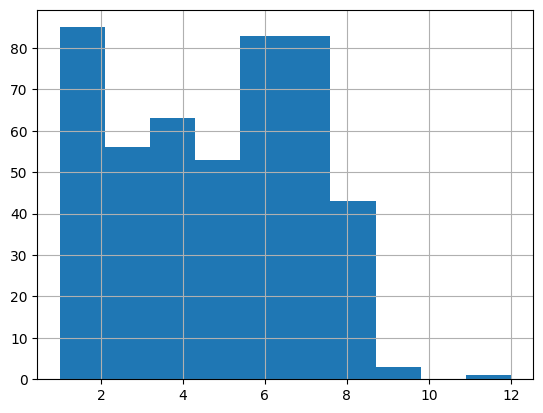

In [255]:
# # Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# # Import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

max_seq_len = 9

# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [256]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,7)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [257]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
# model = model.to(device)
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,799
├─LogSoftmax: 1-7                                       --
Total 

In [268]:
# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 
# We can also use learning rate scheduler to achieve better results
lr_sch = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [269]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        # if step % 50 == 0 and not step == 0:
        # print(f'Batch {step}  of  {len(train_dataloader)}.')
        # push the batch to gpu
        # batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        # print(preds, labels)
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()

        # We are not using learning rate scheduler as of now
        # lr_sch.step()
        # model predictions are stored on GPU. So, push it to CPU
        # preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds.detach().numpy())
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
print('train_losses len =', len(train_losses))
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f'\nTraining Loss: {train_loss:.3f}')
print('train_losses len pt2 =', len(train_losses))

train_losses len = 0

 Epoch 1 / 200

Training Loss: 0.043

 Epoch 2 / 200

Training Loss: 0.034

 Epoch 3 / 200

Training Loss: 0.043

 Epoch 4 / 200

Training Loss: 0.098

 Epoch 5 / 200

Training Loss: 0.004

 Epoch 6 / 200

Training Loss: 0.008

 Epoch 7 / 200

Training Loss: 0.000

 Epoch 8 / 200

Training Loss: 0.097

 Epoch 9 / 200

Training Loss: 0.014

 Epoch 10 / 200

Training Loss: 0.095

 Epoch 11 / 200

Training Loss: 0.051

 Epoch 12 / 200

Training Loss: 0.064

 Epoch 13 / 200

Training Loss: 0.030

 Epoch 14 / 200

Training Loss: 0.031

 Epoch 15 / 200

Training Loss: 0.104

 Epoch 16 / 200

Training Loss: 0.050

 Epoch 17 / 200

Training Loss: 0.022

 Epoch 18 / 200

Training Loss: 0.014

 Epoch 19 / 200

Training Loss: 0.007

 Epoch 20 / 200

Training Loss: 0.014

 Epoch 21 / 200

Training Loss: 0.041

 Epoch 22 / 200

Training Loss: 0.071

 Epoch 23 / 200

Training Loss: 0.014

 Epoch 24 / 200

Training Loss: 0.058

 Epoch 25 / 200

Training Loss: 0.114

 Epoch 26 / 

Text(0, 0.5, 'Training Loss')

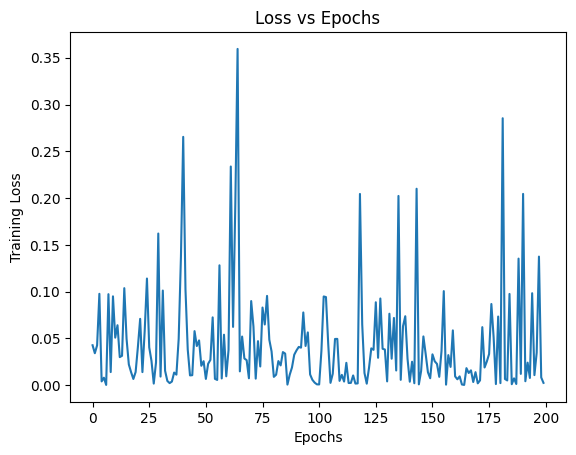

In [270]:
plt.plot([epoch for epoch in range(epochs)], train_losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
# print(train_losses)

In [271]:
def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()

    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])

    preds = model(test_seq, test_mask)
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis = 1)
    print('Intent Identified: ', le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

KEYWORD_TO_GENRE = {
  'scary': 'horror',
}

def get_intent_to_response(intent, keyword):
  return
  # response = 'Sorry, could you repeat that again'
  # if intent == 'start':
  #   response = 'Hello, ask me for movie recommendations!'
  # elif intent == 'question':
  #   response = 'What genre would you like?'
  # elif intent == 'genre':
  #   response = 'how old should the movie be?'
  # elif intent == 'time':
  #   response = 'whose movies would you like to watch'
  # elif intent == 'end':

def get_response(): 
  movie_data = pd.read_csv('./data/movie_data.csv')
  movie_data.head()

  while True:
    message = input('Say something to start')
    intent = get_prediction(message).lower()
    # intent_list = df['Label'].unique()
    response = 'Sorry, could you repeat that again'
    if intent == 'start':
      response = 'Hello, ask me for movie recommendations!'
    elif intent == 'question':
      response = 'What genre would you like?'
    elif intent == 'genre':
      response = 'how old should the movie be?'
    elif intent == 'time':
      response = 'whose movies would you like to watch'
    elif intent == 'end':
      response = 'Goodbye!'
      print(response)
      break
    print(response)

  

#   for i in data['intents']: 
#     if i["tag"] == intent:
#       result = random.choice(i["responses"])
#       break
  # print(f"Response : {'hello'}")
  # return "Intent: "+ intent + '\n' + "Response: " #+ result

In [272]:
get_response()

for i in range(7):
    print(le.inverse_transform([i]))

/Users/mridulmahesh/.local/share/virtualenvs/Project2_latest_version-9wTJLeyD/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Intent Identified:  Start
Hello, ask me for movie recommendations!
Intent Identified:  Rating
Sorry, could you repeat that again
Intent Identified:  Question
What genre would you like?
Intent Identified:  Genre
how old should the movie be?
Intent Identified:  Time
whose movies would you like to watch
Intent Identified:  Cast
Sorry, could you repeat that again
Intent Identified:  Rating
Sorry, could you repeat that again
Intent Identified:  Genre
how old should the movie be?
Intent Identified:  End
Goodbye!
['Cast']
['End']
['Genre']
['Question']
['Rating']
['Start']
['Time']
